<a href="https://colab.research.google.com/github/chethana613/document_clustering/blob/main/Data_Clustering_Project_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
pip install -U scikit-learn

In [44]:
!pip install stop_words

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_20newsgroups

#Here we are fetching the raw data from the 20newsgroup corpora. If no params are given, default shuffle is True.
raw_dataset = fetch_20newsgroups()
#print(raw_dataset)
print(raw_dataset.data[0])

num_documents = len(raw_dataset.data)
num_categories = len(raw_dataset.target_names)

print(f"num_documents:{num_documents}")
print(f"num_categories:{num_categories}")

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





num_documents:11314
num_categories:20


# **Data Cleaning**

In [46]:
#Subset(all) includes all the training and test set data.
#Filtering out the content to analyze the document
# shuffle=False to load the data in the order rather than loading in random order
# loading only useful data and removing un-necessary header etc..
dataset = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'footers', 'quotes'))
print(dataset.data[0])

corpus = dataset.data
gnd_labels = dataset.target #Ground truth labels
print(len(corpus), len(gnd_labels))
print(type(corpus), type(gnd_labels))
print(gnd_labels)
print(dataset.target_names)


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)
18846 18846
<class 'list'> <class 'numpy.ndarray'>
[ 9  4 11 ...  4  6  7]
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


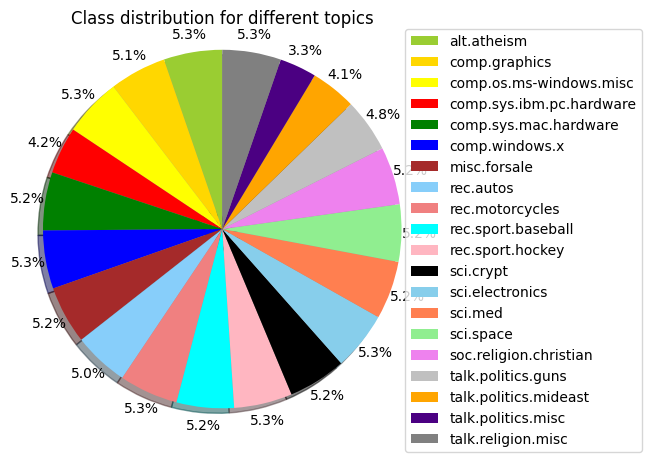

In [47]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
# Counter(labels)
label_20, values = zip(*Counter(gnd_labels).items())
indexes = np.arange(len(label_20))

# plot the labels
label_20 = dataset.target_names
val = values
colors = ['yellowgreen', 'gold', 'yellow', 'red', 'green', 'blue', 'brown', 'lightskyblue', 'lightcoral','cyan','lightpink','black', 'skyblue', 'coral','lightgreen', 'violet', 'silver', 'orange', 'indigo', 'gray']
patches, texts, autotexts = plt.pie(val, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2, autopct='%1.1f%%')

plt.legend(patches, label_20, bbox_to_anchor=(0.95,1.025), loc="upper left")
plt.axis('equal')
plt.tight_layout()
plt.title('Class distribution for different topics')

# Displaying numbers on pie chart slices
for autotext in autotexts:
    autotext.set_color('black')

plt.show()


In [48]:
# First 2 documents
for i in range(2):
    doc = corpus[i]
    category = dataset.target_names[gnd_labels[i]]
    print("The {}-th sent of {}: {}".format(i+1, category, doc))
    print("==================================================\n")

The 1-th sent of rec.sport.baseball: 
morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

The 2-th sent of comp.sys.mac.hardware: Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wou

# Tokenization

In [51]:
# perform more Pre-processing steps
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words

def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    processed_docs = []
    for doc in docs:
        raw_text = doc.lower()
        # tokenization
        tokens_text = tokenizer.tokenize(raw_text)
        # remove stopwords and short tokens
        stopped_tokens_text = [token for token in tokens_text if token not in en_stop and len(token) > 1]
        # remove digits
        doc_without_digits = [token for token in stopped_tokens_text if not token.isnumeric()]
        processed_docs.append(doc_without_digits)
    return processed_docs


# Build Vocabulary

In [52]:
# Preprocess all the documents in the corpus
Vocab_v1 = list(pre_processing(corpus))

# verify length of the clean corpus and print a sample clean tokenized document
print(len(Vocab_v1))
print(Vocab_v1[0])

18846
['morgan', 'guzman', 'will', "era's", 'run', 'higher', 'last', 'year', 'cubs', 'will', 'idiots', 'pitch', 'harkey', 'much', 'hibbard', 'castillo', 'good', 'think', 'stud', 'pitcher']


# **Training Doc2Vec**

In [53]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree #For KNN
from itertools import cycle
from wordcloud import WordCloud
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# Train the Doc2Vec model on the cleaned sentences
start = time.time()
# Set values for various parameters

num_features = 100 # Dimensionality of the hidden layer representation
min_word_count = 20 # Minimum word count to keep a word in the vocabulary
context = 10 # Context window size (on each side)
downsampling = 1e-3 # Downsample setting for frequent words


# Convert documents into TaggedDocument format required by Doc2Vec
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(Vocab_v1)]

# Initialize and train the Doc2Vec model
print("Training model...")
doc2vec_model = Doc2Vec(tagged_data, vector_size=num_features, window=context, min_count=min_word_count, workers=4, epochs=80)

# Infer document vectors
doc_vectors = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data]

print('Total time: ' + str((time.time() - start)) + ' secs')

# Print length of word vectors
len(doc_vectors)



Training model...
Total time: 830.6493792533875 secs


18846

Silhouette Score for k=15: 0.0381443090736866 	 NMI: 0.22404988234771353
Silhouette Score for k=16: 0.004744898993521929 	 NMI: 0.26354079476694486
Silhouette Score for k=17: -0.05058789625763893 	 NMI: 0.21205665788042657
Silhouette Score for k=18: -0.05305391550064087 	 NMI: 0.22508601056143399
Silhouette Score for k=19: -0.06726382672786713 	 NMI: 0.2642311191438596
Silhouette Score for k=20: -0.06857090443372726 	 NMI: 0.2661024188409458
Silhouette Score for k=21: 0.03408609703183174 	 NMI: 0.2631960076760256
Silhouette Score for k=22: -0.06468794494867325 	 NMI: 0.24663359302899496
Silhouette Score for k=23: -0.0828927755355835 	 NMI: 0.2624317398197586
Silhouette Score for k=24: -0.12880408763885498 	 NMI: 0.2778370960072599


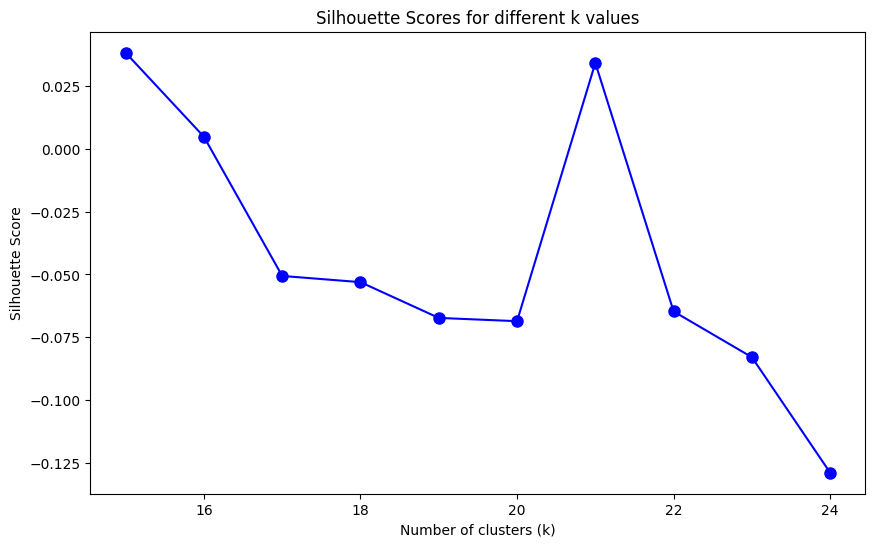

In [59]:
#Finding Cluster value

from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

# Calculate silhouette scores for k values around the suspected optimal number
k_values = range(15, 25)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(doc_vectors)
    silhouette_avg = silhouette_score(doc_vectors, clusters)
    silhouette_scores.append(silhouette_avg)
    nmi = normalized_mutual_info_score(gnd_labels, clusters)
    print(f"Silhouette Score for k={k}: {silhouette_avg} \t NMI: {nmi}")


# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different k values')
plt.show()


Silhouette Score for k=15: 0.03663245216012001 	 NMI: 0.2360638502050147
Silhouette Score for k=16: -0.045787978917360306 	 NMI: 0.24892631336090446
Silhouette Score for k=17: 0.011826744303107262 	 NMI: 0.2794959750468679
Silhouette Score for k=18: 0.02494446188211441 	 NMI: 0.27044948935143415
Silhouette Score for k=19: -0.06970109045505524 	 NMI: 0.2580812663454579
Silhouette Score for k=20: 0.03049297071993351 	 NMI: 0.2501976300797288
Silhouette Score for k=21: -0.03380089998245239 	 NMI: 0.2913296645833053
Silhouette Score for k=22: -0.11279193311929703 	 NMI: 0.2764845938055378
Silhouette Score for k=23: 0.010369007475674152 	 NMI: 0.28710034707774584
Silhouette Score for k=24: -0.07391933351755142 	 NMI: 0.3009295053447948


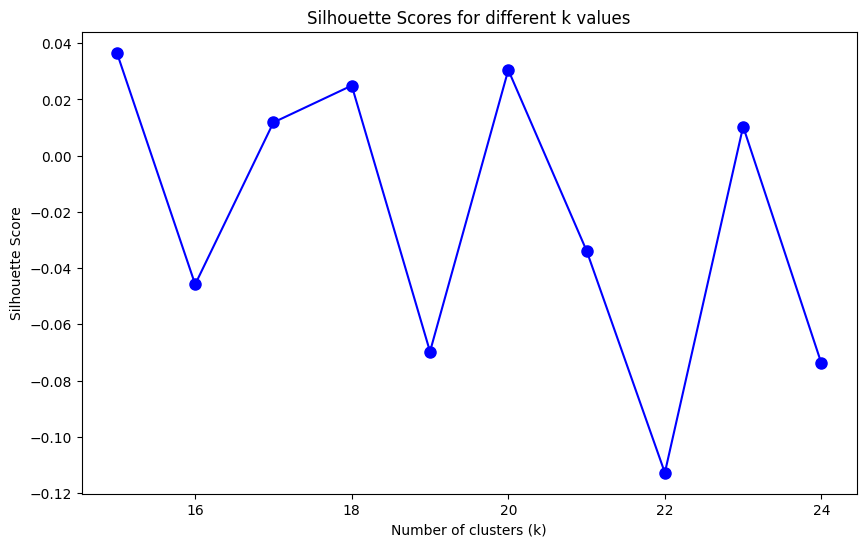

In [60]:
#Finding Cluster value

from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

# Calculate silhouette scores for k values around the suspected optimal number
k_values = range(15, 25)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(doc_vectors)
    silhouette_avg = silhouette_score(doc_vectors, clusters)
    silhouette_scores.append(silhouette_avg)
    nmi = normalized_mutual_info_score(gnd_labels, clusters)
    print(f"Silhouette Score for k={k}: {silhouette_avg} \t NMI: {nmi}")


# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different k values')
plt.show()


#** Classification Metrics**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, gnd_labels, test_size=0.2, random_state=42)

# Initialize SVM classifier
svm_model = SVC()

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict the labels for test data
predicted_labels = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy*100)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')
print("Precision:", precision*100)

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')
print("Recall:", recall*100)

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')
print("F1-score:", f1*100)


Accuracy: 59.310344827586206
Precision: 59.99094255199522
Recall: 58.157704701608424
F1-score: 57.94065208043141


# Training Word2Vec

Training model...


Total time: 12.295699119567871 secs
(100,)


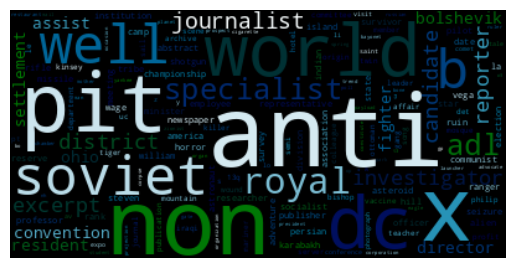

In [ ]:
from gensim.models import word2vec #Library
from sklearn.neighbors import KDTree #For KNN
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
from wordcloud import WordCloud
import time
import pandas as pd


# train the Word2Vec model on the cleaned sentences
start = time.time()
# Set values for various parameters
# Dimensionality of the hidden layer representation
num_features = 100
# Minimum word count to keep a word in the vocabulary
min_word_count = 20
# Context window size (on each side)- Moderate context window
context = 5
# Downsample setting for frequent words
#Used to reduce the influence of very frequent words during training. It helps to speed up training and improve the quality of word vectors by mitigating the dominance of highly frequent words that may not carry as much semantic meaning.
downsampling = 1e-3

# Initialize and train the model.
print("Training model...");
w2v_model = word2vec.Word2Vec(Vocab_v1, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)
# calling init_sims to make the model more memory efficient by normalizing the vectors in-place.
w2v_model.init_sims(replace=True);
# Save the model
model_name = "model_full_20newsGroup";
w2v_model.save(model_name);
print('Total time: ' + str((time.time() - start)) + ' secs')

word_vectors = w2v_model.wv.vectors
print(word_vectors[0].shape)
# print word vector for the first word: 100-element vector with values
word_vectors[0]

# print length of word vectors
len(word_vectors)


# cluster the words using KMeans
num_clusters = 20 #20 topics
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
clusters = kmeans_clustering.fit_predict(word_vectors)
centers = kmeans_clustering.cluster_centers_
centroid_map = dict(zip(w2v_model.wv.index_to_key, clusters))

# get words in each cluster that are closest to the cluster center
# initialize a KDTree on the word vectors, and query it for the Top K words on each cluster center.
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

# get the top words and print the first 2 in each cluster:
top_words = get_top_words(w2v_model.wv.index_to_key, 5000, centers, word_vectors)
top_words[:5]

# Create a word cloud with the words of a cluster and print and save them.
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(0, 20):
    col = next(cmaps)
    display_cloud(i, col)

# **Metrics**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Filter out ground truth labels for words that have corresponding word vectors
filtered_gnd_labels = np.array([gnd_labels[i] for i, word_vector in enumerate(word_vectors) if word_vector is not None])

filtered_gnd_labels = filtered_gnd_labels[np.where(predicted_labels != None)]
accuracy = accuracy_score(filtered_gnd_labels, predicted_labels)
precision = precision_score(filtered_gnd_labels, predicted_labels, average='weighted')
recall = recall_score(filtered_gnd_labels, predicted_labels, average='weighted')
f1 = f1_score(filtered_gnd_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1-score:", f1*100)


Accuracy: 5.251989389920424
Precision: 5.093396220948191
Recall: 5.251989389920424
F1-score: 5.033231837348338


# **Word2Vec Visualization after Dim Reduction**

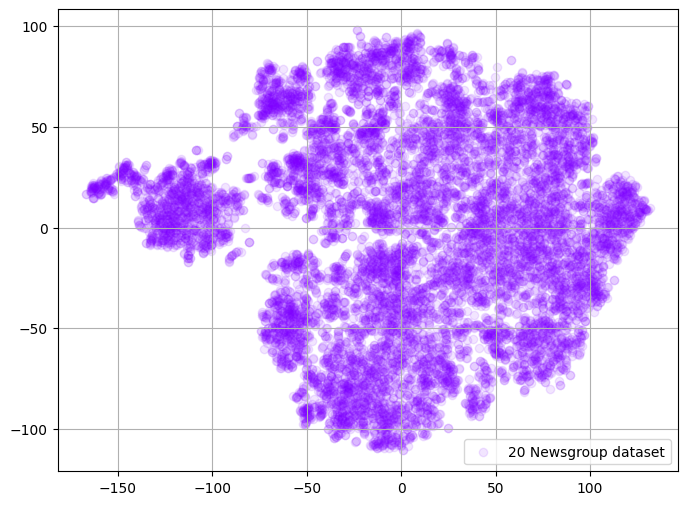

In [ ]:
# Visualize learned word embedding space using t-SNE
words_20ng = []
embeddings_20ng = []
for word in list(w2v_model.wv.index_to_key):
    embeddings_20ng.append(w2v_model.wv[word])
    words_20ng.append(word)

embeddings_20ng = np.array(embeddings_20ng)  # Convert to NumPy array

tsne_w2v_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_w2v_2d = tsne_w2v_2d.fit_transform(embeddings_20ng)


def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(8, 6))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("tsne_plot.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('20 Newsgroup dataset', embeddings_w2v_2d, a=0.1)

# **BOW**

In [ ]:
#Bag-Of-Words document representation method

#This method disregards grammar and word order.
#Counts the frequency of each word in the document and construct a feature vector based on these word counts.

from copy import deepcopy
# Converting words in list to plain text
Vocab_v3 = deepcopy(Vocab_v1)
from itertools import chain
for i in range(0, len(Vocab_v3)):
    data = Vocab_v3[i]
    Vocab_v3[i] = " ".join(str(i) for i in chain(data))

# Generate the bow vectors for the corpus
from sklearn.feature_extraction.text import CountVectorizer
# Initialize an instance of count Vectorizer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(Vocab_v3)

# print shape of the sparse matrix
print(X_counts.shape)
# normalise existing X_counts
from sklearn import preprocessing
X_Norm = preprocessing.normalize(X_counts)

# transforming dataset matrix using SVD
from sklearn.decomposition import TruncatedSVD
# Getting no of components
no_components = 500
print("Number of components: %d" %(no_components))

#Fitting the SVD class
trun_svd1 =  TruncatedSVD(n_components = no_components)
X_transformed = trun_svd1.fit_transform(X_Norm)

# Printing the transformed matrix shape
print("Transformed Matrix:")
print(X_transformed.shape)

# Using this csr sparse matrix, we will perform clustering
from sklearn.cluster import KMeans
import statistics
from sklearn.metrics import normalized_mutual_info_score as NMI
kmeans_bow = KMeans(n_clusters=20)
idx_bow, nmis_bow = [], []
for i in range(3):
    # run K-means
    kmeans_bow.fit_predict(X_transformed)
    # idx.append(the obtained clustering labels)
    idx_bow.append(kmeans_bow.labels_)
    # nmi.append(nmi_score(gnd, clustering label))
    nmis_bow.append(NMI(gnd_labels, kmeans_bow.labels_))

# report mean and std values of nmis
mean = sum(nmis_bow) / len(nmis_bow)
print("NMI mean for K-means: %f" %mean)
variance = sum([((x - mean) ** 2) for x in nmis_bow]) / len(nmis_bow)
std = variance ** 0.5
# Printing result
print("NMI std for BoW K-means: " + str(std))

(18846, 134383)
Number of components: 500
Transformed Matrix:
(18846, 500)
NMI mean for K-means: 0.135768
NMI std for BoW K-means: 0.013630496694176257


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train SVM model using the cluster labels obtained from K-means
svm_model = SVC()
svm_model.fit(X_transformed, idx_bow[0])  # Assuming idx_bow[0] contains the K-means cluster labels

# Predict labels using SVM model
svm_pred_labels = svm_model.predict(X_transformed)

# Evaluate metrics
accuracy = accuracy_score(gnd_labels, svm_pred_labels)
precision = precision_score(gnd_labels, svm_pred_labels, average='weighted')
recall = recall_score(gnd_labels, svm_pred_labels, average='weighted')
f1 = f1_score(gnd_labels, svm_pred_labels, average='weighted')

print("Accuracy:", accuracy * 100)
print("Precision:", precision * 100)
print("Recall:", recall * 100)
print("F1 Score:", f1 * 100)


Accuracy: 4.404117584633345
Precision: 3.2356966152188167
Recall: 4.404117584633345
F1 Score: 3.202776402706981
